In [1]:
from functions import *
from math import pi
import warnings
warnings.filterwarnings('ignore')

# USER TRANSMITTER

Project done by Giulio Conca, Mattia Sandri and Shalini Sree Mada.

Code developed by:
* Giulio Conca (2028844)
* Mattia Sandri (2021425)

Report written by:
* Shalini Sree Mada (2049543)

## INTRODUCTION

The aim of the project is to simulate the transmission of a sequence of messages, transmitted by a user placed on the surface of the Moon and received by a satellite in orbit. The signal at the receiver is sampled in I/Q samples, that are quantized and then written inside a binary file. The software produces one binary file for each transmitted packet.

The messages to transmit are either ACKs or NACKs and the signals associated to each packet is obtained by using the Binary Offset Carrier BOC(1,1) modulation.
The software simulates the propagation through the channel by introducing an attenuation in the transmitted signal and a delay due to the propagation. The noise, that is supposed to be AWGN, is included directly in the I/Q samples, before the quantization. 

All the functions used in this notebook are stored inside the "functions.py" file, provided in the delivered folder.

**Note**: for the development of the project, we first show the entire process for the first packet to transmit (showing all the functions one by one), to let the reader understand the process, and then we run a for cycle on the remaining packets by calling all the functions one after the other.

## LOADING ALL THE FILES

The first thing to do is loading all the files that contain the parameters used for the software: the settings.ini file and the N_ACK.csv file (that contains the messages that are supposed to be ACKed or NACKed), while the output of the orbit propagator group, that contains the orbit information, will be loaded later.

In [2]:
f = open('settings.ini')
settings = json.load(f)
 
for i in settings:
    print(i, end=': ')
    print(settings[i])
    
f.close()

#the transmitted power is in Watt, while the transmitter and receiver gains are in dB, as well as the SNR

fSampling: 4092000.0
quantizationBits: 16
scenarioDuration: 5.05
SV_PRN_ID: 1
CRCpolynomial: A23DCB
SYNCpattern: 0101100000
TAILpattern: 000000
SVIDlength: 6
MIDlength: 4
MBODYlength_TX: 80
MBODYlength_ACK: 30
CRClength: 24
nPRN_x_Symbol: 1
nChip_x_PRN: 4092
chipRate: 1023000.0
bitRate: 250
maxDoppler: 100000.0
transmitterGain: 30
receiverGain: 15
transmittedPower: 27
SNR: 15


In [3]:
#reading the file with the packets to transmit: if GOOD = 1 it's an ACK, if GOOD = 0 it's a NACK

acks = pd.read_csv("N_ACK.csv")
num_packets = acks.shape[0]
print("Packets to transmit: ", num_packets)
acks

Packets to transmit:  5


,MSGID,GOOD
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


Now we need to create the messages, and we store them into a matrix. Each row of the matrix corresponds to a message.

In [4]:
#we create the empty matrix that will contain all the packets (each row of the matrix is a packet). Each packet
#has a length of 80 bits. The CRC is of 24 bits

packet_length = len(settings['SYNCpattern']) + len(settings['TAILpattern']) + settings['SVIDlength'] + settings['MIDlength'] + settings['MBODYlength_ACK'] + 24 
packets_matrix = np.zeros(shape=(num_packets, packet_length), dtype=np.int8)

#each row of the file is added to a list called N_ACK. Based on the value of the GOOD column, either a ACK or 
#a NACK is generated, by using the function createMessageAck (or createMessageNack), defined inside the functions
#file

f = open('N_ACK.csv')
csv_file = csv.reader(f)
N_ACK = []
for row in csv_file:
        N_ACK.append(row)
        
for i in range(len(N_ACK)-1):
    if(N_ACK[i+1][1]=='1'):
        msg = createMessageACK(settings['SYNCpattern'], settings['SV_PRN_ID'], int(N_ACK[i+1][0]))
    if(N_ACK[i+1][1]=='0'):
        msg = createMessageNACK(settings['SYNCpattern'], settings['SV_PRN_ID'], int(N_ACK[i+1][0]))
    packets_matrix[i] = msg

#packets_matrix = packets_matrix.astype(np.int)
print("\nMatrix of packets:")
print(packets_matrix)


Matrix of packets:
[[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0
  1 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0
  0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1
  0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1
  0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1
  1 1 0 0 0 0 0 0]]


In [5]:
filename = "E1B - Gal.txt"

# defining the name of the column of the dataframe called e1b
columns = ["Hexadecimal"]

#reading the file
e1b = pd.read_table(filename, sep="\r\n", header=None, names=columns)

# deleting the first 15 characters (not part of the code)
e1b['Hexadecimal'] = [el[16::] for el in e1b['Hexadecimal']]

# creating a new column with the codes indexes and placing it as first column
e1b['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1b = e1b.reindex(columns=column_list)

# printing the first lines of the dataframe
e1b.head()

,Code index,Hexadecimal
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...


In [6]:
# creation of a new column of the dataframe with the binary representation of each PRN
e1b['Binary'] = e1b['Hexadecimal'].apply(hex2bin)

#creation of a copy of the dataframe to use without modifying the original dataframe
e1bcopy = e1b.copy()
e1b.head()

,Code index,Hexadecimal,Binary
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."


In [7]:
#To verify if the conversion was successful, we print the last code in binary:
#To check the last PRN, the reader can look at the last row in the file "E1b - Gal.txt" in the folder

# since the last code starts with 9 7 ... in hexadecimal, the binary representation should start with 
# 1001 0111 ...
# and since it ends with ... 2 0, the binary representation should end with
# ... 0010 0000

print("First 8 bits: ", e1b['Binary'][49][0:8])    
print("Last 8 bits: ", e1b['Binary'][49][-8:])    

First 8 bits:  [1 0 0 1 0 1 1 1]
Last 8 bits:  [0 0 1 0 0 0 0 0]


To obtain the BOC(1,1) modulation we need first to modify the PRNs, as explained in the report, in order to obtain values equal to 1 and -1 (and not 1 and 0 as before). This is done by adding a new column to the dataframe. The conversion is done by the corresponding function (see functions file).

In [8]:
#we create different dataframes to avoid any modification of the original ones
e1bmodified = e1b.copy()
e1bmodified['Modified'] = e1bmodified['Binary'].apply(conversion)

e1bmodifiedcopy = e1bmodified.copy()
e1bmodified.head()

,Code index,Hexadecimal,Binary,Modified
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[-1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[-1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1,..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...","[-1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1,..."


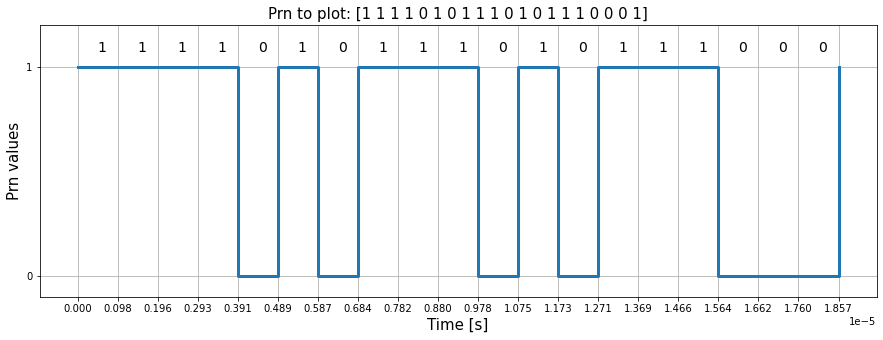

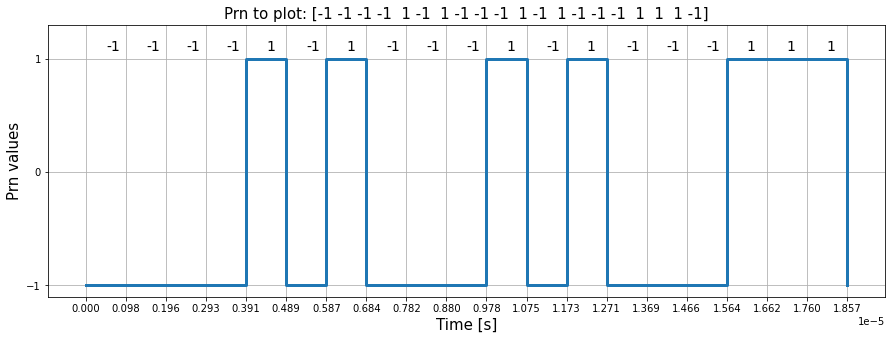

In [9]:
#this is a plot of the first 20 chips of the first PRN in the dataframe, just to visualize it as a signal
plot_prn_zeros(20, e1bcopy['Binary'][0], settings['chipRate'])

#this is a plot to show the same PRN after the conversion
plot_prn_modified(20, e1bmodifiedcopy['Modified'][0], settings['chipRate'])

## BOC(1,1) MODULATION

As explained in the report, the BOC(1,1) modulation is obtained by multiplying the data message (with symbol period $T_b$), the PRN sequence (with chip period $T_c$) and a NRZ subcarrier with period $T_p = T_c$. The multiplication by the sinusoidal carrier is not needed, since we are supposed to work in baseband.

The only thing that we miss is the subcarrier, that is generated in the following cell.

Subcarrier length: 654720
First 20 samples of the subcarrier:  [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1]


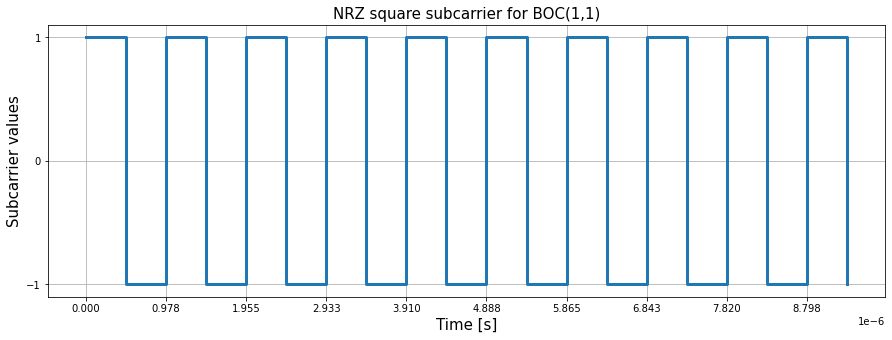

In [10]:
#Now we generate the BOC subcarrier, that is a square NRZ wave. The period of the waveform is given by Tc.

#The needed length of the subcarrier is 654720. This is because the spreaded sequence is composed of 327360
#symbols (data message is 80 symbols, and each symbol is spreaded with a PRN, that has 4092
#chips, so 80*4092 = 327360) and each symbol of the spreaded sequence (with duration of Tc) is kept constant for 2 
#samples of the subcarrier, therefore 327360*2 = 654720. 

subcarrier_length = packet_length*settings['nPRN_x_Symbol']*settings['nChip_x_PRN']*2

Rc = settings['chipRate']   # chip rate
Tc = 1 / Rc     # chip period 

rep = 2 
s = np.array([1, -1])
subcarrier = np.tile(s, int(subcarrier_length/2)) # we repeat the values 1 and -1 for 327360 times in order to have an array of 654720 elements                     

#now we plot the first 20 samples of the subcarrier
xticks = np.arange(0,10*Tc, Tc)
yticks = [-1, 0, 1]

t = np.arange(0, 10*Tc, Tc/2)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.step(t, subcarrier[0:20], where='post', lw=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_title('NRZ square subcarrier for BOC(1,1)', fontsize=15)
ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel('Subcarrier values', fontsize=15)
ax.grid()

print("Subcarrier length:", len(subcarrier))  
print("First 20 samples of the subcarrier: ", subcarrier[0:20])

Now that we have the subcarrier, we can do the modulation using the function called "boc", that returns the modulated signal and the plot of the first samples of it.

To start, we consider the first packet, but later this must be done to all the packets inside the matrix.

In [11]:
message = packets_matrix[0]
print("\n", message)


 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0]


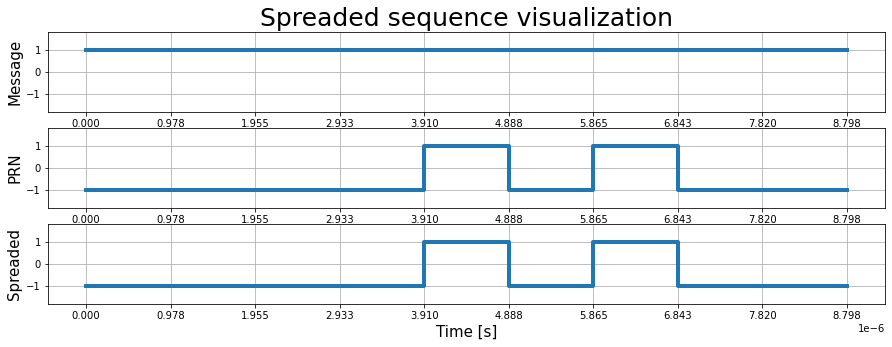

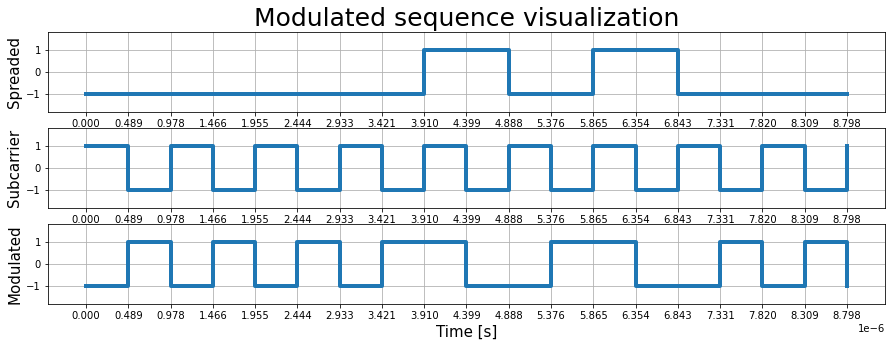


Modulated message:
 [-1.  1. -1. ...  1.  1. -1.]


In [12]:
modulated = boc(message, subcarrier, settings["bitRate"], settings["chipRate"], 
                np.array(e1bmodifiedcopy['Modified']), settings['SV_PRN_ID'], settings['nPRN_x_Symbol'], True)
print("\nModulated message:\n", modulated)

## SAMPLING OF THE SIGNAL

The following step consists in sampling the signal. The sampling frequency, contained in the settings.ini file, is set to 4.092 MHz. As explained in the report, it's a good choice since it is a multiple of the chip rate.
Since the modulated signal has a sample every $\frac{T_c}{2}$ seconds, and we use a sampling period of $\frac{T_c}{4}$, to simulate the sampling we just need to repeat each value of the modulated signal twice. This is done by the "sampling" function.

In [13]:
#for the sampling function, we also need to pass the total time vector, i.e. the time vector of all the packets
#at the transmitter. To compute it we also need the final length of the modulated signal after the sampling

final_length = int(len(modulated)*(0.5*(1/settings['chipRate']) / (1/settings['fSampling'])))   #1309440

total_time_vector_tx = np.arange(0, num_packets*final_length*(1/settings['fSampling']), 1/settings['fSampling'])
print(total_time_vector_tx)

[0.00000000e+00 2.44379277e-07 4.88758553e-07 ... 1.59999927e+00
 1.59999951e+00 1.59999976e+00]


In [14]:
#the function returns the sampled signal and also the corresponding time vector
modulated_sampled, t_sampled = sampling(modulated, settings['fSampling'], 0.5*(1/settings['chipRate']), 
                                        total_time_vector_tx, 0, True)

Before sampling: [-1.  1. -1.  1. -1.  1. -1.  1.  1.]
After sampling:  [-1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.]
Length after sampling: 1309440

Time vector: [0.00000000e+00 2.44379277e-07 4.88758553e-07 ... 3.19999267e-01
 3.19999511e-01 3.19999756e-01]
Time vector length: 1309440


## POWER OF THE SIGNAL

To simulate the effect of the high power amplifier we multiply our signal by the square root of the transmitted power.


Signal ready for the transmission:  [-5.19615242 -5.19615242  5.19615242 ...  5.19615242 -5.19615242
 -5.19615242]


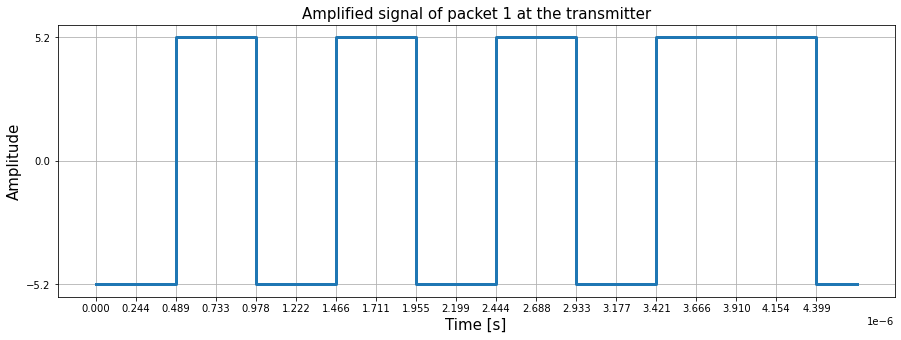

In [15]:
signal_to_tx = hpa(modulated_sampled, t_sampled, settings['transmittedPower'], 0, True)
print("\nSignal ready for the transmission: ", signal_to_tx)

#from the plot it seems that the time vector is always the same even if we change the index of the packet. With a 
#different index passed to the sampling function, the time vector that is returned is different.
#The multiplicative factor of the x axis (bottom right corner of the plot) changes by changing the index

## PROPAGATION THROUGH THE CHANNEL AND RECEIVED POWER

As explained in the report, the formula to compute the received power is the following:

$P_r = P_t - P_L + G_t + G_r$  (dB)

All the parameters are set in the settings file, while the free space path loss is provided by the orbit propagator group.

We simulate the signal at the receiver by introducing a time delay due to the propagation through the channel, and we multiply the original modulated signal (the one we had at the transmitter before the amplification) by $\sqrt{P_r}$. At this point we will compute the I/Q samples and we will add to them the noise, whose power $P_n$ is retrieved by inverting the SNR formula.

Those samples are going to be quantized and written in a binary file.

First we load the orbit propagator file:

In [16]:
#here we load the file provided by the orbit propagator group
filename = "OrbitalDATA.txt"
orbit = pd.read_table(filename, header=0, sep=' ')
orbit = orbit.dropna(axis=0)

#we also want to consider the Free Space Path Loss in dB, so we add a column to the dataframe
orbit['FSPL[dB]'] = orbit['FSPL'].apply(lin2dB)

#in order to estimate also the propagation delay, we can just divide the pseudorange (satellite-user distance)
#by the speed of light. Therefore we create another column in the dataframe
c = 299792458   #speed of light in vacuum in m/s
orbit['PropDelay[s]'] = orbit['Pseudorange[m]']/c

#adding a column for the indexes
orbit['Index'] = np.arange(0, orbit.shape[0], 1)
column_list = ["Index","Date", "Time", "Siminstant[s]", "Pseudorange[m]", "FSPL", "CodeDelay[chips]", 
               "DopplerShift[Hz]", "FSPL[dB]", "PropDelay[s]"]
orbit = orbit.reindex(columns=column_list)

orbit

,Index,Date,Time,Siminstant[s],Pseudorange[m],FSPL,CodeDelay[chips],DopplerShift[Hz],FSPL[dB],PropDelay[s]
1,0,2022-06-01,09:10:37.830,4237.84,1.745497e+06,5.602320e+09,1864.260,3.45376,97.483679,0.005822
2,1,2022-06-01,09:10:37.840,4237.85,1.745486e+06,5.602250e+09,1864.230,3.45376,97.483625,0.005822
3,2,2022-06-01,09:10:37.850,4237.86,1.745476e+06,5.602190e+09,1864.190,3.45376,97.483578,0.005822
4,3,2022-06-01,09:10:37.860,4237.87,1.745466e+06,5.602120e+09,1864.160,3.45376,97.483524,0.005822
5,4,2022-06-01,09:10:37.870,4237.88,1.745456e+06,5.602060e+09,1864.130,3.45376,97.483478,0.005822
...,...,...,...,...,...,...,...,...,...,...
34337,34336,2022-06-01,09:16:21.190,4581.20,1.400148e+06,3.604770e+09,685.810,3.37927,95.568776,0.004670
34338,34337,2022-06-01,09:16:21.200,4581.21,1.400138e+06,3.604720e+09,685.776,3.37927,95.568715,0.004670
34339,34338,2022-06-01,09:16:21.210,4581.22,1.400128e+06,3.604670e+09,685.742,3.37926,95.568655,0.004670
34340,34339,2022-06-01,09:16:21.220,4581.23,1.400118e+06,3.604620e+09,685.708,3.37926,95.568595,0.004670


The duration of the message associated to a packet is equal to $1309440 \cdot T_s = 0.32$ seconds. In the orbit dataframe the sampling period to compute the values of the observables is 10 ms, therefore 0.32 seconds (320 ms) corresponds to the first 320/10 = 32 rows of the dataframe. 
In this short period of time the free space path loss and the propagation delay change in a trascurable way, as shown in the following cell.

In [17]:
print("FSPL of the first row: ", orbit['FSPL[dB]'][1])
print("FSPL of the 32th row: ", orbit['FSPL[dB]'][32])
print("Difference: ", np.abs(orbit['FSPL[dB]'][1] - orbit['FSPL[dB]'][32]))

print("\nPseudorange of the first row: ", orbit['PropDelay[s]'][1])
print("Pseudorange of the 32th row: ", orbit['PropDelay[s]'][32])
print("Difference: ", np.abs(orbit['PropDelay[s]'][1] - orbit['PropDelay[s]'][32]))

FSPL of the first row:  97.48367911746578
FSPL of the 32th row:  97.48211292158848
Difference:  0.0015661958773023343

Pseudorange of the first row:  0.005822349681892264
Pseudorange of the 32th row:  0.005821303087251114
Difference:  1.046594641149895e-06


Since the difference is negligible, in order to simplify the simulation we are going to consider a constant FSPL for the transmission of each packet. Another simplification that we consider is the following: since the packets are going to be transmitted one after the other, we can consider the propagation delay only once, and it will be the delay we observe when we start the transmission. We assume to start the transmission at the time that corresponds to the first line of the orbit dataframe.

Moreover, since the Doppler frequencies and the FSPL provided in the file are updated every 10 ms, while our sampling period is equal to $T_s = \frac{T_c}{4}$ seconds (that is way lower), we need to interpolate them.
But while the FSPL is considered at the beginning of the transmission of each packet, the doppler frequencies are computed at the time corresponding to the transmission time plus the propagation delay, in order to obtain the dopplers at the receiver.

## RECEIVED SIGNAL

The received signal will be characterized by a multiplicative factor given by $\sqrt{P_r}$ and a time vector that has a length equal to 1309440 (with the original settings parameter), starts at the propagation delay $\tau_p$ (since we assumed to start the transmission, that is our time 0, at the first line of the orbit dataframe) and has one sample every $T_s = \frac{T_c}{4}$ seconds, such as the transmitted signal. Therefore, for the signal referred to the first packet:

Propagation delay:  0.005822349681892264
Amplitude after the channel:  0.012300773656756107

Received signal:  [-0.01230077 -0.01230077  0.01230077 ...  0.01230077 -0.01230077
 -0.01230077]
Corresponding time vector [0.00582235 0.00582259 0.00582284 ... 0.32582162 0.32582186 0.32582211]


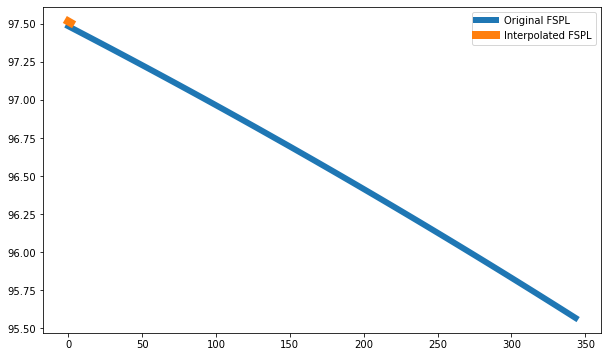

In [18]:
#to compute the amplitude of the received signal we need to do first the interpolation of FSLP
#because the received power depends on the FSPL
 
#This is the vector of the total FSPL we observe during the process (considering all the packets)
total_FSPL = GetFSPL(orbit['FSPL[dB]'].to_numpy(), 0.01, 0, final_length*num_packets, 1/settings['fSampling'], True)

#we also compute the total time vector (associated to all the packets) at the receiver (therefore it starts from
#the propagation delay)
prop_delay = orbit['PropDelay[s]'][1]
print("Propagation delay: ", prop_delay)
total_time_vector_rx = total_time_vector_tx + prop_delay

#amplitude of the first packet (with index 0)
amplitude = return_amplitude(total_FSPL, 0, settings['transmittedPower'], settings['transmitterGain'], 
                             settings['receiverGain'], final_length)
print("Amplitude after the channel: ", amplitude)

#received signal 
received_signal = amplitude*modulated_sampled
print("\nReceived signal: ", received_signal)

#time vector associated to the received signal (of the first packet, therefore index = 0)
time_vector = return_time_vector(total_time_vector_rx, 0, final_length)
print("Corresponding time vector", time_vector)

## I/Q SAMPLES AT THE RECEIVER

The following step consists in generating the I/Q samples that, as explained in the report, are simply obtained by multiplying the received signal $s(t)$ by a cosine and a sine function:

$x_I(t) = s(t)\,\cos\,(2\,\pi\,f'\,t)$

$x_Q(t) = s(t)\,\sin\,(2\,\pi\,f'\,t)$

where $f'$ is a vector that contains all the Doppler frequencies computed during the process. This is because the I/Q samples are supposed to be generated in baseband, therefore there is no carrier frequency to consider in this case. The interpolation of the Doppler frequencies (starting from the propagation delay) are obtained in the following cell, using the function "GetDopplerShift".

In [19]:
#as before we compute first the total doppler shifts vector, that are then going to be split for each packet.
total_dopplers = GetDopplerShift(orbit['DopplerShift[Hz]'], 0.01, prop_delay, final_length*num_packets, 
                                 1/settings['fSampling'], False)

#dopplers for the first packets (index = 0)
dopplers = return_dopplers(total_dopplers, 0, final_length)
print("Dopplers of the first message: ", dopplers)

Dopplers of the first message:  [3.45667262 3.45667262 3.45667262 ... 3.45667256 3.45667256 3.45667256]


Now we can compute the I/Q samples for the first message.

I samples:  [-0.01220255 -0.01220255  0.01220254 ...  0.0086289  -0.00862886
 -0.00862881]

Q samples:  [-0.00155135 -0.00155142  0.00155148 ...  0.00876647 -0.00876652
 -0.00876657]


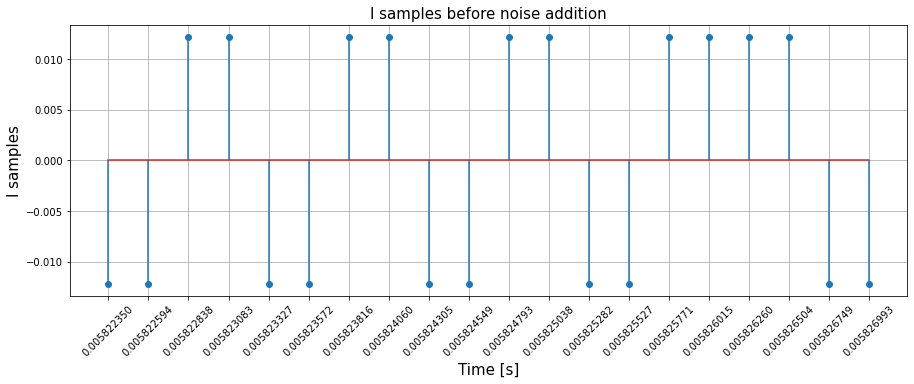

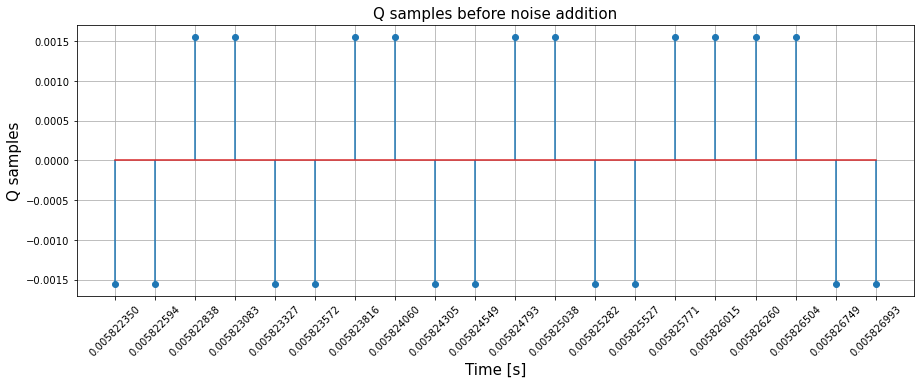

In [20]:
I, Q = IQ_samples(received_signal, time_vector, dopplers, True)
print("I samples: ", I)
print("\nQ samples: ", Q)

Now we need to add the noise, whose power is computed by inverting the SNR formula.

In [21]:
received_power = amplitude**2
noise_power_dB = lin2dB(received_power) - settings['SNR']     #in the settings file, the SNR is in dB

I_noise = awgn(I, noise_power_dB, True)  
print("I samples after noise: ", I_noise)

Q_noise = awgn(Q, noise_power_dB, False)
print("\nQ samples without noise: ", Q_noise)

#for the I samples the flag is True, so the noise is added and they differ from the I samples printed in the 
#previous cell

#for the Q samples the flag is False and no noise is added, as specified in the instructions
#They are the same Q samples of the previous cell

#Now we add the noise also to the Q samples
Q_noise = awgn(Q, noise_power_dB, True)
print("\nQ samples after noise: ", Q_noise)

I samples after noise:  [-0.00938304 -0.01258814  0.01661187 ...  0.01167378 -0.00776617
 -0.00966479]

Q samples without noise:  [-0.00155135 -0.00155142  0.00155148 ...  0.00876647 -0.00876652
 -0.00876657]

Q samples after noise:  [ 2.93765983e-05 -3.75048690e-03  1.97199062e-03 ...  6.64699045e-03
 -8.46951172e-03 -1.07098276e-02]


The final step consists in quantizing those values and writing them in a binary file. 
The quantization was done by truncating the values (floating point of some length) into floating point of 16 bits. To achieve this, we use the float16 type given by the numpy module. This type is structured as: 1 sign bit, 5 bits exponent, 10 bits mantissa. Of course, the receiver must be aware of this choice.

In [22]:
I_quantized = quantizationFloat(I_noise, settings['quantizationBits'])
Q_quantized = quantizationFloat(Q_noise, settings['quantizationBits'])

print(I_quantized)
print(Q_quantized)

[-0.009384 -0.01259   0.01662  ...  0.01167  -0.007767 -0.00967 ]
[ 2.939e-05 -3.750e-03  1.972e-03 ...  6.645e-03 -8.469e-03 -1.071e-02]


Finally, the samples are written in a binary file.

In [23]:
filename = "signal_binary_" + str(0) + ".bin"
writeFileFloat(filename, I_quantized, Q_quantized)

In [24]:
#to understand if the last step was correctly done we read again the samples from the binary files and we 
#compare them with the samples we obtained after the quantization

I_quantized_read, Q_quantized_read = readQuantizedFloat(filename, settings['quantizationBits'], 10)
print("First 5 quantized I samples:", I_quantized[0:5])
print("First 5 I samples from file:", I_quantized_read)
print("\nFirst 5 quantized Q samples:", Q_quantized[0:5])
print("First 5 Q samples from file:", Q_quantized_read)

First 5 quantized I samples: [-0.009384 -0.01259   0.01662   0.01089  -0.00994 ]
First 5 I samples from file: [-0.009384 -0.01259   0.01662   0.01089  -0.00994 ]

First 5 quantized Q samples: [ 2.939e-05 -3.750e-03  1.972e-03  3.130e-03 -4.601e-03]
First 5 Q samples from file: [ 2.939e-05 -3.750e-03  1.972e-03  3.130e-03 -4.601e-03]


## ALL THE OTHER PACKETS

In [25]:
#Note: in the following for cycle, we don't print the messages/signals after the various transformations
#This is because the first part and the last part of the messages are always equal, since the first and last
#part of the message is equal (synchro pattern and tail), since the PRN is always the same and since the 
#subcarrier for the boc modulation is always the same.
#On the other hand, it would be pointless to print some samples of the signals in the middle region, because
#from that it's very hard to get any information.
#Therefore printing some values of the signals would just mess up the code and the for cycle itself.

#we use a for loop over all the rows of the matrix, skipping the first row (first packet)
for i in range(1, packets_matrix.shape[0]):
    
    message = packets_matrix[i]
    print("Packet of index", i, ":\n", message, "\n")
    
    #first step: modulation
    modulated = boc(message, subcarrier, settings["bitRate"], settings["chipRate"], 
                    np.array(e1bmodifiedcopy['Modified']), settings['SV_PRN_ID'], settings['nPRN_x_Symbol'], False)
    
    #second step: sampling
    modulated_sampled, t_sampled = sampling(modulated, settings['fSampling'], 0.5*(1/settings['chipRate']), 
                                        total_time_vector_tx, i, False)

    #third step: high power amplifier
    signal_to_transmit = hpa(modulated_sampled, t_sampled, settings['transmittedPower'], 1, False)
    
    #fourth step: simulating the signal at the receiver
    amplitude = return_amplitude(total_FSPL, i, settings['transmittedPower'], settings['transmitterGain'], 
                                 settings['receiverGain'], final_length)
    received_signal = amplitude*modulated_sampled
    time_vector = return_time_vector(total_time_vector_rx, i, final_length)
    print("Time vector of the signal corresponding to packet", i, "at rx:\n", time_vector)
    
    #fifth step: I/Q samples
    dopplers = return_dopplers(total_dopplers, i, final_length)
    I, Q = IQ_samples(received_signal, time_vector, dopplers, False)
    
    #sixth step: noise
    received_power = amplitude**2
    noise_power_dB = lin2dB(received_power) - settings['SNR']  
    print("\nNoise power of the signal corresponding to packet", i, "at rx:\n", dB2lin(noise_power_dB))

    I_noise = awgn(I, noise_power_dB, True)
    Q_noise = awgn(Q, noise_power_dB, True)
    print("\nI samples after noise of packet of index", i, ":\n", I_noise, "\n")
    print("Q samples after noise of packet of index", i, ":\n", Q_noise, "\n")
    
    #seventh step: quantization
    I_quantized = quantizationFloat(I_noise, settings['quantizationBits'])
    Q_quantized = quantizationFloat(Q_noise, settings['quantizationBits'])
    
    #last step: binary file
    filename = "signal_binary_" + str(i) + ".bin"
    writeFileFloat(filename, I_quantized, Q_quantized)
    print('-----------------------------------------------------------------------------------------\n')


Packet of index 1 :
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1
 0 0 0 0 0 0] 

Time vector of the signal corresponding to packet 1 at rx:
 [0.32582235 0.32582259 0.32582284 ... 0.64582162 0.64582186 0.64582211]

Noise power of the signal corresponding to packet 1 at rx:
 4.78677742045902e-06

I samples after noise of packet of index 1 :
 [-0.01260172 -0.00455429  0.00584905 ... -0.00013307 -0.00373421
 -0.00087287] 

Q samples after noise of packet of index 1 :
 [-0.00810716 -0.00840428  0.01035407 ...  0.01168359 -0.0139391
 -0.01358491] 

-----------------------------------------------------------------------------------------

Packet of index 2 :
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1
 0 0 0 0 0 0] 

Time vector of the signal corresponding to packet 2 at rx:
 [0.6458